# Description of the project

**our project will use the NLP(Natural Processing Language) to find out if a person has a positive or negative emotions using his tweets ,So it's a simple application of data science,but it can be developped using advanced tools of Machine Learning .** <br />**we will extract the feedback of "yellow vest strick"**

# Introduction

Twitter (www.twitter.com) have evolved to become a great
source of various kinds of information. This is due to the nature of microblogs on which people
post real-time messages regarding their opinions on a variety of topics, discuss current issues,
complain, and express many kinds of emotions. 
Current sentiment analysis methods typically focus on the polarity of like/dislike emotions.
Sometimes neutral emotions can be detected in between. Human emotions are far beyond these
simple metrics and are much more diverse. This implies that such polarity analysis gives only
limited information on the actual intent of the author of the message. Defining either positive
or negative emotions only is relatively simple, yet defining a complete and clear set of emotions
is much more difficult. Researchers have thus created a wide range of research tools on the
identification of basic emotions.


### import the necessary libraries 

In [1]:
# tweepy supports accessing Twitter via Basic Authentication

from tweepy import API # special for the APIs twitter
from tweepy import Cursor # Cursor used to extract user tweets on timeline
from tweepy.streaming import StreamListener # StreamListener used to process live tweets.
from tweepy import OAuthHandler # OAuthHandler used to intercat with tweets using the user credentials
from tweepy import Stream 
#text used to processing textual data. It provides a simple API for diving into common natural language processing (NLP) .
from textblob import TextBlob
 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re # re used to split a stream of text into smaller units called tokens, usually words or phrases

to use the APIs we need to create an application on twitter because Twitter provides REST APIs you can use to interact with their service and some useful data from it,<br /> **Steps**<br /> log-in to Twitter (if you’re not already logged in) and register a new application. You can now choose a name and a description for your app (for example “Mining data” or similar). You will receive a **consumer key** and a **consumer secret**: these are application settings that should always be kept private. From the configuration page of your app, you can also require an **access token** and an **access token secret**. Similarly to the consumer keys, these strings must also be kept private: they provide the application access to Twitter on behalf of your account.

In [2]:
# Variables that contains the user credentials to access Twitter API 
ACCESS_TOKEN = "YOUR_ACCESS_TOKEN"
ACCESS_TOKEN_SECRET = "YOUR_ACCESS_TOKEN_SECRET"
CONSUMER_KEY = "YOUR_CONSUMER_KEY"
CONSUMER_SECRET = "YOUR_CONSUMER_SECRET"
 

### Create Class Twitter Client


the class will be used to get information about any well known user of twitter (timeline_ tweets, freinds etc)

In [3]:
class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)

        self.twitter_user = twitter_user

    def get_twitter_client_api(self):
        return self.twitter_client

    def get_user_timeline_tweets(self, num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets

    def get_friend_list(self, num_friends):
        friend_list = []
        for friend in Cursor(self.twitter_client.friends, id=self.twitter_user).items(num_friends):
            friend_list.append(friend)
        return friend_list

    def get_home_timeline_tweets(self, num_tweets):
        home_timeline_tweets = []
        for tweet in Cursor(self.twitter_client.home_timeline, id=self.twitter_user).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets

### Create Class Twitter Authenticator

the class use the user credentials to access Twitter API 

In [4]:
class TwitterAuthenticator():

    def authenticate_twitter_app(self):
        auth = OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
        auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
        return auth



### Create Class Twitter Streamer

this Class to Handle data received from the stream.


In [5]:
class TwitterStreamer():
    def __init__(self):
        self.twitter_autenticator = TwitterAuthenticator()    

    def stream_tweets(self, fetched_tweets_filename, hash_tag_list):
        # This handles Twitter authetification and the connection to Twitter Streaming API
        listener = TwitterListener(fetched_tweets_filename)
        auth = self.twitter_autenticator.authenticate_twitter_app() 
        stream = Stream(auth, listener)

        # This line filter Twitter Streams to capture data by the keywords: 
        stream.filter(track=hash_tag_list)

### Create Class Twitter Listener

This is a basic listener that just prints received tweets to stdout.


In [6]:
class TwitterListener(StreamListener):
    
    def __init__(self, fetched_tweets_filename):
        self.fetched_tweets_filename = fetched_tweets_filename

    def on_data(self, data):
        try:
            with open('tweets_gilet_jaune.json', 'a') as f:
                f.write(data)
                return True
        except BaseException as e:
            print("Error on_data: %s" % str(e))
        return True
 
    def on_error(self, status):
        if status == 420:
             print(status)
        return True


### Create Tweet Analyzer

Functionality for analyzing and categorizing content from tweets.


In [7]:
class TweetAnalyzer():


    def clean_tweet(self, tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

    def analyze_sentiment(self, tweet):
        analysis = TextBlob(self.clean_tweet(tweet))
        # if the tweet is good retrun 1
        # if the tweet is neutral return 0
        # if the tweet 
        if analysis.sentiment.polarity > 0:
            return 1
        elif analysis.sentiment.polarity == 0:
            return 0
        else:
            return -1

    def tweets_to_data_frame(self, tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['tweets'])

        df['id'] = np.array([tweet.id for tweet in tweets])
        df['len'] = np.array([len(tweet.text) for tweet in tweets])
        df['date'] = np.array([tweet.created_at for tweet in tweets])
        df['source'] = np.array([tweet.source for tweet in tweets])
        df['likes'] = np.array([tweet.favorite_count for tweet in tweets])
        df['retweets'] = np.array([tweet.retweet_count for tweet in tweets])

        return df


### Put it together

In [21]:
if __name__ == '__main__':

    twitter_client = TwitterClient()
    tweet_analyzer = TweetAnalyzer()

    api = twitter_client.get_twitter_client_api()

    tweets = api.user_timeline(screen_name="appropriateabby", count=200)

    df = tweet_analyzer.tweets_to_data_frame(tweets)
    # create the column which contains our analysis of sentiments
    df['sentiment'] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df['tweets']])
# print the first ten tweets 
df.head(10)

,tweets,id,len,date,source,likes,retweets,sentiment
0,RT @DisparatePost: TAX on a TAX! Yes. You read...,1073859512443043841,139,2018-12-15 08:37:13,Twitter Web Client,0,23,-1
1,RT @caulmick: Direland \n\nSheltered area outs...,1073859232632659969,139,2018-12-15 08:36:07,Twitter Web Client,0,29,-1
2,RT @caulmick: Simon Harris has been accused of...,1073859176013721600,140,2018-12-15 08:35:53,Twitter Web Client,0,5,0
3,RT @caulmick: Almost eight years of Fine Gael ...,1073859114982404096,140,2018-12-15 08:35:39,Twitter Web Client,0,11,-1
4,RT @caulmick: THOUSANDS OF FRANCE’S #YellowVes...,1073858928482680832,140,2018-12-15 08:34:54,Twitter Web Client,0,10,0
5,RT @Trickstersworld: Local Authorities in Dubl...,1073858744935698432,140,2018-12-15 08:34:10,Twitter Web Client,0,5,1
6,"RT @chezmik: 'I felt so low, so useless': Meat...",1073855101754859521,133,2018-12-15 08:19:42,Twitter Web Client,0,6,0
7,RT @silenced_wont: How much did this cost me i...,1073854311413755905,140,2018-12-15 08:16:33,Twitter Web Client,0,3,-1
8,Solidarity comrades!!! #IStandWithTheToryMPStr...,1073853701486460929,79,2018-12-15 08:14:08,Twitter Web Client,0,0,0
9,RT @caulmick: Social devastation here in Irela...,1073716895243747329,140,2018-12-14 23:10:31,Twitter Web Client,0,159,-1


### Visualisation of Analysis


#### the number of likes between the date (2018-12-12 13:14:17 and 2018-12-15 08:37:13) 3 days

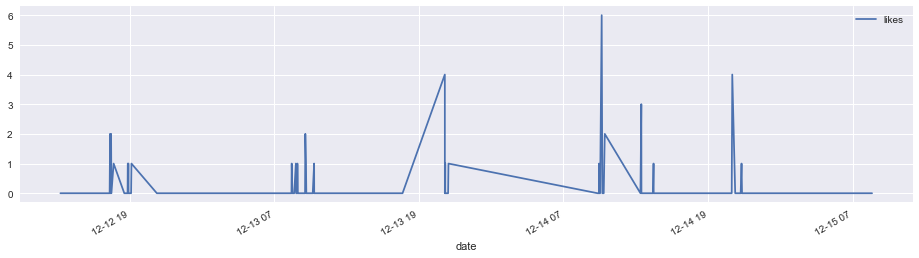

In [23]:
import seaborn
seaborn.set()
#Layered Time Series:
time_likes = pd.Series(data=df['likes'].values, index=df['date'])
time_likes.plot(figsize=(16, 4), label="likes", legend=True)


we see that the are some increases and decreases of retweets and the hightest number of retweets was 6 at the date 12-14-09

#### the number of retweets between the date (2018-12-12 13:14:17 and 2018-12-15 08:37:13) 3 days

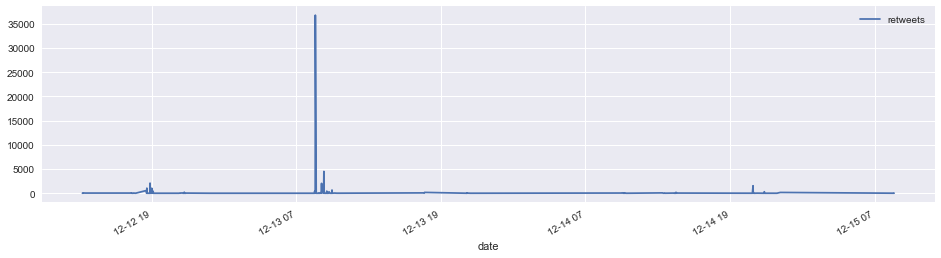

In [24]:
time_retweets = pd.Series(data=df['retweets'].values, index=df['date'])
time_retweets.plot(figsize=(16, 4), label="retweets", legend=True)

we see that the number increase at the date 12-13-07 

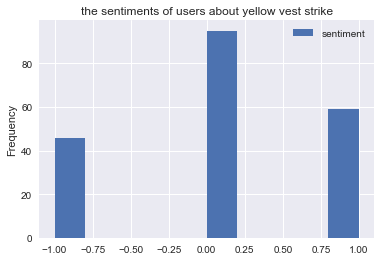

In [41]:
time_likes = pd.Series(data=df['sentiment'].values, index=df['date'])
time_likes.plot(kind="hist", label="sentiment", title="the sentiments of users about yellow vest strike" , legend=True)
plt.show()

we see that most of user's are neutral maybe because our analysis comes after that the strike was broken,but the number of 1 is more than the number of -1, so we can say that almost of people have a positive impact of the strike of yellow vest, and the strike was successful.